In [1]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

train_data.shape

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(404, 13)

##### 准备数据

In [2]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

##### 构建模型

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

##### K折交叉验证

In [4]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_mae_histories = []
for i in range(k):
    print('Processing fold #', i)
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
        axis=0
    )
    model = build_model()
    history = model.fit(
        partial_train_data, partial_train_targets,
        epochs=num_epochs, batch_size=16, verbose=0
    )
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_mae_histories.append(val_mae)

Processing fold # 0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing fold # 1
Processing fold # 2
Processing fold # 3


In [5]:
all_mae_histories

[1.8718173503875732,
 2.6338279247283936,
 2.4932854175567627,
 2.2438995838165283]

In [6]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('Processing fold #', i)
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
        axis=0
    )
    model = build_model()
    history = model.fit(
        partial_train_data, partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=16, verbose=0
    )
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [15]:
len(all_mae_histories)

4

In [13]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

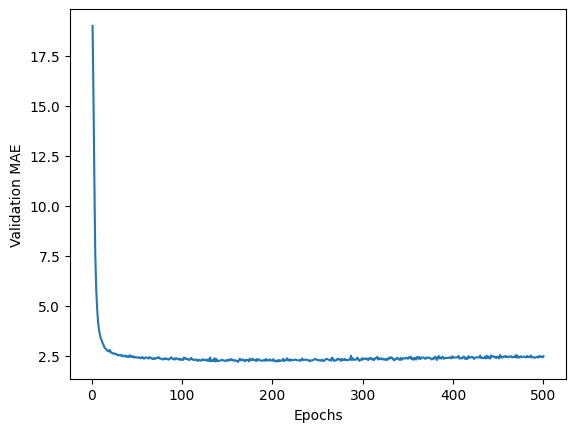

In [16]:
from matplotlib import pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

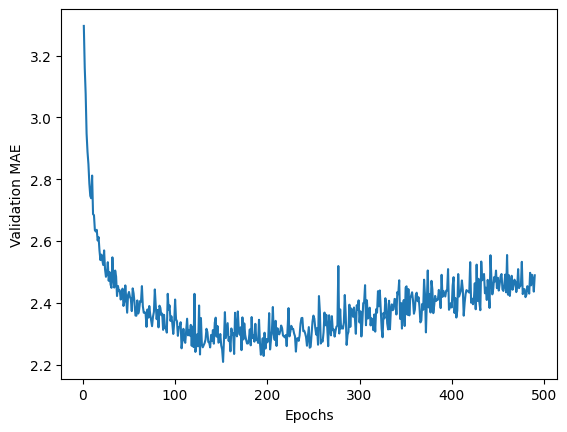

In [17]:
truncated_average_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_average_mae_history) + 1), truncated_average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [18]:
model = build_model()
model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print('Test MAE:', test_mae_score)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.5628 - mae: 2.3413
Test MAE: 2.537809133529663
